## Create Panorama
This example shows how to automatically stitch multiple images into panorama. The procedure for image stitching is an extension of feature based image registration. Instead of registering a single pair of images, multiple image pairs are successively registered relative to each other to form a panorama.

### Load Images
The image set used in this example contains pictures of [daeyun’s test hill images](https://github.com/daeyun/Image-Stitching/tree/master/img/hill). These were taken with an uncalibrated smart phone camera by sweeping the camera from left to right along the horizon, capturing all parts of the hill. The images are relatively unaffected by any lens distortion so camera calibration was not required. However, if lens distortion is present, the camera should be calibrated and the images undistorted prior to creating the panorama.

In [1]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils import *

Images loaded successfully!


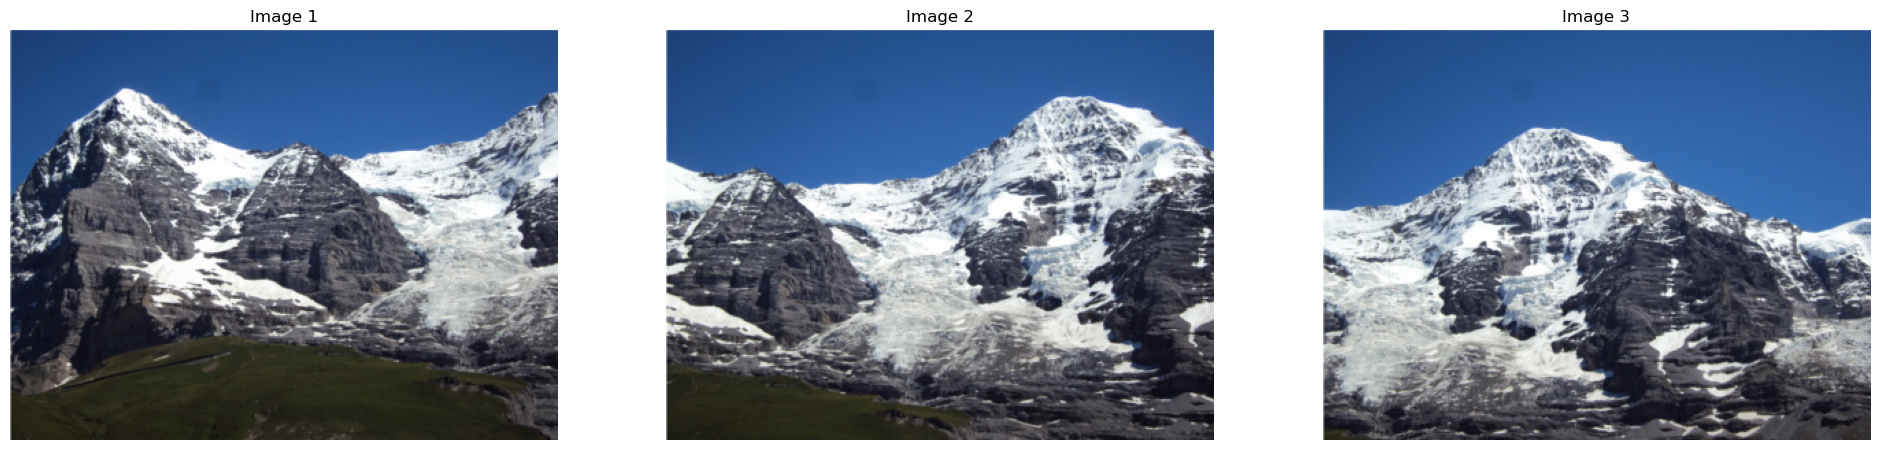

In [2]:
# Load and Display Images
path = "./data/hill"
images = load_images(path) # Loads images into an array

### Register Image Pairs
To create the panorama, start by registering successive image pairs using the following procedure:

1. Detect and match features between I(n) and I(n−1).

2. Estimate the geometric transformation, T(n), that maps I(n) to I(n−1).

3. Compute the transformation that maps I(n) into the panorama image as T(1)∗T(2)∗...∗T(n−1)∗T(n).

Initialize features of an image:

In [3]:
def detect_and_compute_keypoints(img):
    """
    Detect keypoints and compute descriptors for each image using SIFT.
    """
    sift = cv2.SIFT_create()
    keypoints = []
    descriptors = []
    keypoints = sift.detect(img, None)
    keypoints, descriptors = sift.compute(img, keypoints)

    return keypoints, descriptors

In this project, homographies (projective transformations) are applied to stitch images together. A homography is suitable here because our datasets consist of planar scenes with only translational movement and negligible rotation between camera poses.

Homographies represent 2D projective transformations, and it effectively models the relationships in planar scenes. However, for general 3D transformations, fundamental/essential matrices are used. 

In [4]:
def stitch_images(img1, img2, kp1, kp2, matches):
    """
    Stitch two images together using matched keypoints and RANSAC to find homography.
    This version adds padding based on detected alignment (left or right).
    """
    # Extract matched keypoints
    img1_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    img2_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    
    # Compute homography matrix using RANSAC
    H, mask = cv2.findHomography(img1_pts, img2_pts, cv2.RANSAC, 5.0)
    img1_warped, img2_padded = warpPerspectivePadded(img1, img2, H)
    stitched_image = masking(img1_warped, img2_padded, 0.5)
    result = np.uint8(stitched_image)
    
    return result

Iterate images and incrementally stitch them at each step to create the panorama. At each step, the features of the current image are matched with the stitched image with all the previous input images. Then, the homography between the two images is calculated using the matched SIFT features, which is then used to add the new image into the panorama. The canvas size (stitched image) is dynamically computed at each step to accommodate the new image (look at warpPerspectivePadded in utils.py). 

In [5]:
def create_panorama(images):
    """
    Create a panorama from a list of images.
    """
    stitched_image = images[0]  # Start with the first image
    for i in range(1, len(images)):
        print(f"Stitching image {i-1} and {i}...")
        keypoints1, descriptors1 = detect_and_compute_keypoints(stitched_image)
        keypoints2, descriptors2 = detect_and_compute_keypoints(images[i])
        
        # Match features
        matches = match_features(descriptors1, descriptors2)
        print(f"Number of good matches between stitched image and image {i}: {len(matches)}")

        draw_matches(stitched_image, images[i], keypoints1, keypoints2, matches, num_matches=30)
        
        # Stitch the current pair of images
        stitched_image = stitch_images(stitched_image, images[i], keypoints1, keypoints2, matches)
    
    return stitched_image


Stitching image 0 and 1...
Number of good matches between stitched image and image 1: 506


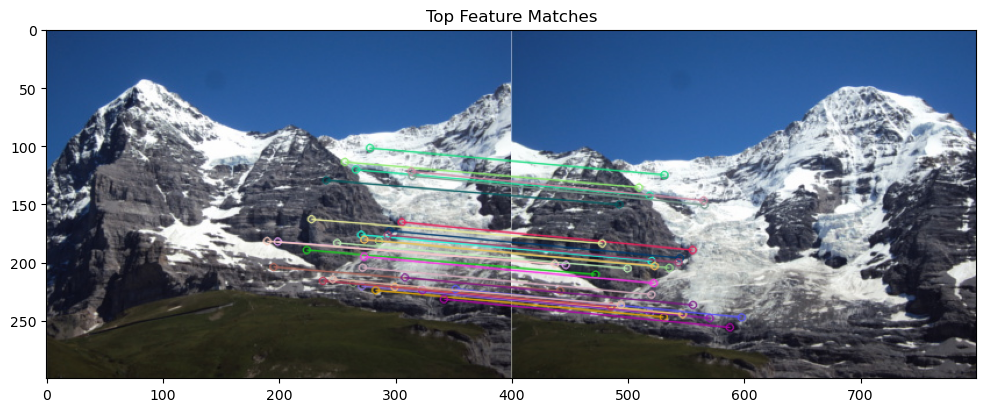

Stitching image 1 and 2...
Number of good matches between stitched image and image 2: 690


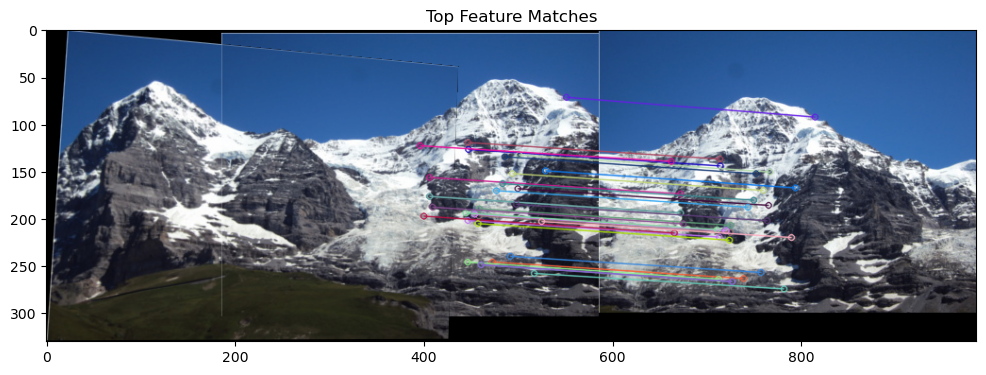

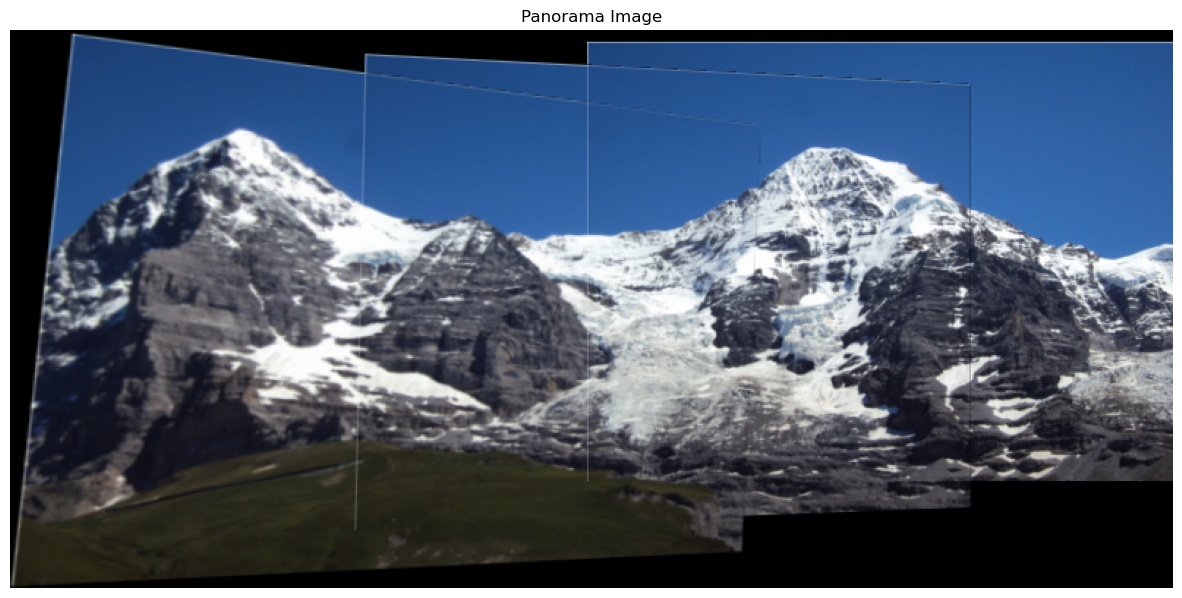

In [6]:
panorama = create_panorama(images)

# Display the final panorama
plt.figure(figsize=(15, 10))
plt.imshow(panorama)
plt.title("Panorama Image")
plt.axis("off")
plt.show()

### References
[1] Matthew Brown and David G. Lowe. 2007. Automatic Panoramic Image Stitching using Invariant Features. Int. J. Comput. Vision 74, 1 (August 2007), 59-73.